In [1]:
import numpy as np
from neuralStellar import *
import pymc3 as pm
import corner

In [2]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
m1.getWeights()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

In [11]:
file='grid_0_0.csv'
small_grid=stellarGrid(file)
small_grid.buildIndex()
small_grid.popIndex(['','star_mass','star_age','star_feh',None,'star_MLT','effective_T','luminosity','delta_nu'])
small_grid.initialData()

iso_ages=np.array([4.5])
#iso_ages=10**np.linspace(np.log10(0.1),np.log10(8),30)
age_width=0.05*iso_ages
iso_feh=0
iso_MLT=1.9
Teffs = []
Ls = []
delnus = []
masses = []
ages = []
for i,iso_age in enumerate(iso_ages):
    for d in small_grid.data:
        if d[small_grid.indices['age']] > iso_age-age_width[i] and d[small_grid.indices['age']] < iso_age+age_width[i]:
            Teffs.append(d[small_grid.indices['Teff']])
            Ls.append(d[small_grid.indices['L']])
            delnus.append(d[small_grid.indices['delnu']])
            masses.append(d[small_grid.indices['mass']])
            ages.append(d[small_grid.indices['age']])

Data headers = 
['', 'model_number', 'star_mass', 'star_age', 'star_feh', 'star_MLT', 'star_fov', 'effective_T', 'luminosity', 'radius', 'log_g', 'surface_h1', 'surface_he4', 'center_h1', 'center_he4', 'log_center_T', 'log_center_Rho', 'he_core_mass', 'delta_nu', 'delta_Pg', 'nu_max', 'nu_0_10', 'nu_0_11', 'nu_0_12', 'nu_0_13', 'nu_0_14', 'nu_0_15']


In [29]:
'''
#mass mean - lognormal
M_mu_mu = 1
M_mu_sigma = 5
#mass sigma - half normal
M_sigma_sigma = 5
'''

#age mean - lognormal
Age_mu_mu = 4.5
Age_mu_sigma = 0.1
#age sigma - half normal
Age_sigma_sigma = 0.1

N = len(Teffs)

model = pm.Model()
with model:
    #M_mu = pm.Lognormal('mean_mass', np.log10(M_mu_mu), M_mu_sigma)
    #M_sigma = pm.HalfNormal('spread_mass', M_sigma_sigma)
    
    BoundAge_mu = pm.Bound(pm.Normal,lower=0)
    Age_mu = BoundAge_mu('mean_age', Age_mu_mu, Age_mu_sigma)
    #Age_mu = pm.Lognormal('mean_age', np.log10(Age_mu_mu), Age_mu_sigma)
    Age_sigma = pm.HalfNormal('spread_age', Age_sigma_sigma)
    
    #M = pm.Normal('mass', M_mu, M_sigma, shape=N)
    #BoundM = pm.Bound(pm.Lognormal,lower=0)
    M = pm.Uniform('mass',lower=0.8, upper=1.2, shape=N)
    BoundAge = pm.Bound(pm.Normal,lower=0)
    Age = BoundAge('age',Age_mu,Age_sigma, shape=N)
    feh = np.zeros(N)
    MLT = np.ones(N)*1.9
    
    obs = pm.Deterministic('obs',m1.manualPredict([np.log10(M), np.log10(Age), feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0],0.1, observed=Ls)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1],70, observed=Teffs)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=delnus)

start = {'mean_age': 4, 'spread_age': 0.5}
with model:
    trace = pm.sample(init='adapt_diag', start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age, mass, spread_age, mean_age]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 2000/2000 [22:02<00:00,  5.22s/draws]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.966175868831328, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.009733753220727271, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller

In [33]:
pm.summary(trace, var_names=['mean_age','spread_age','mass','age'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean_age,3.773135,0.022938,0.002294,3.750197,3.796074,1.001001,461615.701173
spread_age,0.532829,0.003912,0.000391,0.528917,0.536740,1.001001,198498.868219
mass__0,0.987931,0.000745,0.000075,0.987186,0.988676,1.001001,16234.490529
mass__1,0.988028,0.000478,0.000048,0.987549,0.988506,1.001001,2848.996713
mass__2,0.988009,0.000726,0.000073,0.987283,0.988736,1.001001,3946.504783
mass__3,0.988347,0.000191,0.000019,0.988156,0.988538,1.001001,3123.287505
mass__4,0.988521,0.000650,0.000065,0.987871,0.989170,1.001001,5744.790832
mass__5,0.997270,0.000303,0.000030,0.996967,0.997572,1.001001,171010.946791
mass__6,0.997148,0.000269,0.000027,0.996878,0.997417,1.001001,61906.805605
mass__7,0.997356,0.000164,0.000016,0.997192,0.997519,1.001001,651255.069742


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000219BF530A58>,
      dtype=object)

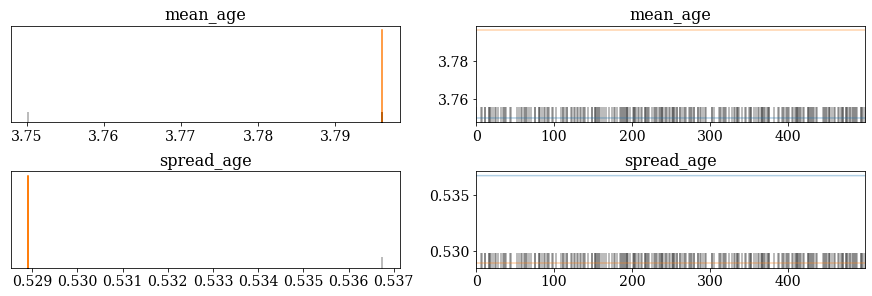

In [34]:
pm.plots.traceplot(trace,var_names=['mean_age','spread_age'])

(1000, 329)


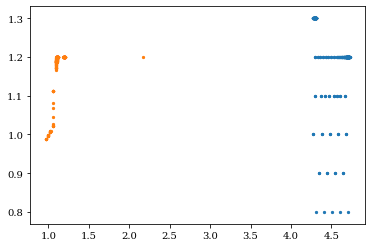

In [35]:
mean_masses=[]
mean_ages=[]
for i,m in enumerate(trace['mass'].T):
    mean_masses.append(np.mean(m))
    mean_ages.append(np.mean(trace['age'].T[i]))
plt.scatter(ages,masses,s=5)
plt.scatter(mean_ages,mean_masses,s=5)
print(np.shape(trace['mass']))